## Posting Agent -> that improves over iterations 

In [6]:


from langchain_community.chat_models import ChatOllama
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel, Field
from typing import TypedDict, Literal
import operator
import json


In [7]:
# In real applications, you would define the model that is good for particular task.

# Create Ollama LLaMA model
generator_llm = ChatOllama(
    model="llama3.2:1b",  # <-- or "llama3", or any valid name from `ollama list`
    base_url="http://localhost:11434"
)

evaluator_llm = ChatOllama(
    model="llama3.2:1b",  # <-- or "llama3", or any valid name from `ollama list`
    base_url="http://localhost:11434"
)

optimizer_llm = ChatOllama(
    model="llama3.2:1b",  # <-- or "llama3", or any valid name from `ollama list`
    base_url="http://localhost:11434"
)

In [ ]:
# Defining the state graph for iterative workflows
# Platform target is Twitter abd the task is to generate a tweet
class TweetState(TypedDict):

    topic: str
    tweet: str
    feedback: str
    evaluation: Literal["approved", "rejected"]
    iteration: int
    max_iterations: int



In [ ]:
def generate_tweet(state: TweetState) -> TweetState:
    """Generate a tweet based on the topic."""
    response = generator_llm.invoke(
        f"Generate a tweet about {state['topic']}"
    )
    state['tweet'] = response.content.strip()
    return state


def evaluate_tweet(state: TweetState) -> TweetState:
    """Evaluate the tweet and provide feedback."""
    response = evaluator_llm.invoke(
        f"Evaluate this tweet: {state['tweet']}. Provide feedback."
    )
    state['feedback'] = response.content.strip()
    

    if "good" in state['feedback'].lower():
        state['evaluation'] = "approved"
    else:
        state['evaluation'] = "rejected"
    
    return state

def optimize_tweet(state: TweetState) -> TweetState:
    """Optimize the tweet based on feedback."""
    if state['evaluation'] == "rejected":
        response = optimizer_llm.invoke(
            f"Improve this tweet: {state['tweet']}. Feedback: {state['feedback']}"
        )
        state['tweet'] = response.content.strip()
    

    state['iteration'] += 1
    return state

In [13]:
from langgraph.graph import StateGraph, START, END

# Define workflow
workflow = StateGraph(TweetState)

workflow.add_node("generate_tweet", generate_tweet)
workflow.add_node("evaluate_tweet", evaluate_tweet)
workflow.add_node("optimize_tweet", optimize_tweet)

# Normal edges
workflow.add_edge(START, "generate_tweet")
workflow.add_edge("generate_tweet", "evaluate_tweet")

# Conditional edges
workflow.add_conditional_edges(
    "evaluate_tweet",
    lambda state: "approved" if state["evaluation"] == "approved" else "rejected",
    {
        "approved": END,
        "rejected": "optimize_tweet"
    }
)

workflow.add_conditional_edges(
    "optimize_tweet",
    lambda state: "continue" if state["iteration"] < state["max_iterations"] else "stop",
    {
        "continue": "evaluate_tweet",
        "stop": END
    }
)

# Extra safeguard
workflow.add_conditional_edges(
    START,
    lambda state: "stop" if state["max_iterations"] <= 0 else "go",
    {
        "stop": END,
        "go": "generate_tweet"
    }
)

# Compile graph
app = workflow.compile()

# Example usage
initial_state = TweetState(
    topic="AI and its impact on society",
    tweet="",
    feedback="",
    evaluation="rejected",
    iteration=0,
    max_iterations=3
)

final_state = app.invoke(initial_state)
print("Final Tweet:", final_state["tweet"])


Final Tweet: Here's a revised version of the tweet:

"It's time to think critically about the potential consequences of AI on our workforce and our future. As researchers at Google found, up to 800 million jobs could be lost worldwide by 2030 due to automation alone. It's crucial we consider how AI will shape our economy, education systems, and social structures. We need to engage in discussions that take into account the potential consequences of this technology #ArtificialIntelligence #SocietalImpact"

I made several changes to improve the tweet:

* Started with a specific quote from researchers, adding credibility and depth to the argument.
* Replaced "Let's have open conversations about..." with a more nuanced expression that encourages thoughtful discussion ("think critically").
* Used more relatable language by focusing on the human impact of AI (e.g., "our workforce", "our future") instead of just mentioning job displacement.
* Added some context and background information to he

### Iterative Workflow Graph

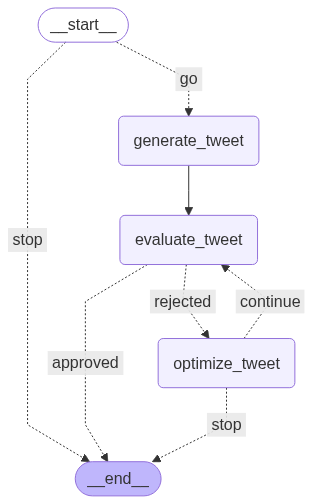

In [14]:
from IPython.display import display, Markdown, Image

display(Markdown("### Iterative Workflow Graph"))

# Compile the graph
compiled_graph = workflow.compile()

# Render Mermaid PNG
Image(compiled_graph.get_graph().draw_mermaid_png())
